## Evaluate Fast-RCNN model directly from python

This notebook demonstrates eveluation of a model trained by the Fast-RCNN implementation of CNTK.

For a full description of the model and the algorithm, please see the following tutorial: https://github.com/Microsoft/CNTK/wiki/Object-Detection-using-Fast-R-CNN 

Below, you will see sample code for:
1. Preparing the input data for the network (including image size adjustments)
2. Evaluation of the input data using the model
3. Processing the evluation result and presenting the selected regions back on the image

Before running this notebook, please make sure that:
<ol>
<li>You have version >= 2.0 of CNTK installed. Installation instructions are available here: https://github.com/Microsoft/CNTK/wiki/Setup-CNTK-on-your-machine

The current assumption is that you have CNTK installed on a windows machine under "c:\local\cntk". You can change the path for the CNTK by changing the "cntk_base_path" variable that is defined below.</li>

<li>You trained the Fast R-CNN model example for the groecry dataset run according to the instructions in the [tutorial above](https://github.com/Microsoft/CNTK/wiki/Object-Detection-using-Fast-R-CNN).<br>
**Important**: Please note that this example works with the Brain Script model that supports version 2.0 of CNTK.
To use the brainscript model, make sure to use following fastrnn.cntk configuration file: https://github.com/Microsoft/CNTK/blob/pkranen/frcnPythonApi/Examples/Image/Detection/FastRCNN/fastrcnn.cntk

The configuration uses the BrainScript version for the AlexNet. Prior to running the A2_RunCntk.py script, you should download the model from: https://www.cntk.ai/Models/AlexNet/AlexNetBS.model and place it under the: "<i>C:\local\cntk\Examples\Image\PretrainedModels</i>" directory.</li>

<li>This notebook uses the CNTK python APIs and should be run from the CNTK python enviornment. The enviornment can be started by running the script: "c:\local\cntk\Scripts\cntkpy34.py".</li>
</ol>

In [249]:
%matplotlib inline
# the above line enable us to draw the images inside the notebooks

# path to the CNTK installation
cntk_base_path = r"C:\local\cntk"

## load the model:

In [250]:
from cntk import load_model
from os.path import join
frcnn_model = load_model(join(cntk_base_path, r"Examples/Image/Detection/FastRCNN/proc/grocery_2000/cntkFiles/Output/Fast-RCNN.model"))

## Load image and convert it to the network format

The image is loaded using OpenCV, and then resized according to the network input dimensions.

When resizing, we preserve scale and pad the border areas with a constant value (114)

(-0.5, 999.5, 999.5, -0.5)

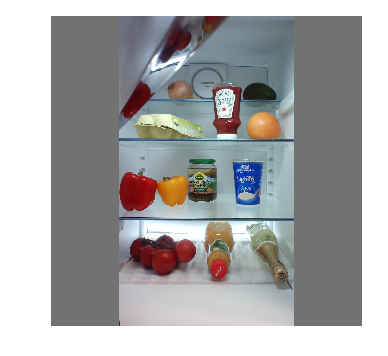

In [230]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_height = 1000
image_width = 1000 

def load_resize_and_pad(img, width, height, pad_value=114):
    # port of the c++ code from CNTK: https://github.com/Microsoft/CNTK/blob/f686879b654285d06d75c69ee266e9d4b7b87bc4/Source/Readers/ImageReader/ImageTransformers.cpp#L316
    img_width = len(img[0])
    img_height = len(img)
    
    scale_w = img_width > img_height
    
    target_w = width
    target_h = height
    
    if scale_w:
        target_h = int(np.round(img_height * float(width) / float(img_width)))
    else:
        target_w = int(np.round(img_width * float(height) / float(img_height)))
        
    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)
    
    top = int(max(0, np.round((height - target_h) / 2)))
    left = int(max(0, np.round((width - target_w) / 2)))
    
    bottom = height - top - target_h
    right = width - left - target_w
    
    resized_with_pad = cv2.copyMakeBorder(resized, top, bottom, left, right, 
                                          cv2.BORDER_CONSTANT, value=[pad_value, pad_value, pad_value])
        
    #tranpose(2,0,1) converts the image to the HWC format which CNTK accepts
    model_arg_rep = np.ascontiguousarray(np.array(resized_with_pad, dtype=np.float32).transpose(2,0,1))
    
    return resized_with_pad, model_arg_rep

def load_image_and_scale(image_path, width, height, pad_value=114):
    img = cv2.imread(image_path)
    return resize_and_pad(img, width, height, pad_value), img

test_image_path = join(cntk_base_path, r"Examples/Image/DataSets/grocery/testImages/WIN_20160803_11_28_42_Pro.jpg")
(test_img, test_img_model_arg), original_img = load_image_and_scale(test_image_path, image_width, image_height)

plt.imshow(cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB))
plt.axis("off")

## Define ROIs for testing

Current ROI data is taken from the example test file. 
ROIs can be produced using a sliding window/selective search. The given ROIs are in the format of [x,y,w,h] and in the coordinates of the scaled and padded image.

The ROIs are padded with regions of [0,0,0,0] at the end to match the 2000 ROIs model.

We use a helper function to find where the pading start and store the length of the actual list without the padding in order to use it later in the evaluation.

As a final step, we also convert the coordinate of the ROIs back to the coordinates of the original image

In [26]:
import numpy as np
rois_sample = "0.219 0.0 0.165 0.29 0.329 0.025 0.07 0.115 0.364 0.0 0.21 0.13 0.484 0.0 0.075 0.06 0.354 0.045 0.055 0.09 0.359 0.075 0.095 0.07 0.434 0.155 0.04 0.085 0.459 0.165 0.145 0.08 0.404 0.12 0.055 0.06 0.714 0.235 0.06 0.12 0.659 0.31 0.065 0.075 0.299 0.16 0.1 0.07 0.449 0.18 0.19 0.15 0.284 0.21 0.135 0.115 0.254 0.205 0.07 0.055 0.234 0.225 0.075 0.095 0.239 0.23 0.07 0.085 0.529 0.235 0.075 0.13 0.229 0.24 0.09 0.085 0.604 0.285 0.12 0.105 0.514 0.335 0.1 0.045 0.519 0.335 0.08 0.045 0.654 0.205 0.08 0.055 0.614 0.215 0.115 0.065 0.609 0.205 0.115 0.075 0.604 0.225 0.115 0.055 0.524 0.23 0.06 0.095 0.219 0.315 0.065 0.075 0.629 0.31 0.095 0.08 0.639 0.325 0.085 0.06 0.219 0.41 0.25 0.11 0.354 0.46 0.185 0.11 0.439 0.515 0.09 0.075 0.359 0.455 0.175 0.125 0.449 0.525 0.08 0.07 0.574 0.46 0.06 0.105 0.579 0.46 0.105 0.1 0.529 0.47 0.15 0.145 0.584 0.475 0.085 0.09 0.354 0.52 0.08 0.06 0.219 0.52 0.115 0.1 0.229 0.53 0.1 0.08 0.229 0.575 0.105 0.045 0.339 0.56 0.085 0.045 0.354 0.535 0.075 0.06 0.299 0.59 0.145 0.05 0.304 0.58 0.12 0.045 0.594 0.555 0.075 0.05 0.534 0.58 0.14 0.06 0.504 0.66 0.07 0.06 0.494 0.73 0.075 0.09 0.504 0.695 0.07 0.095 0.219 0.665 0.075 0.145 0.494 0.755 0.085 0.075 0.704 0.665 0.07 0.21 0.434 0.72 0.055 0.1 0.569 0.695 0.205 0.185 0.219 0.73 0.29 0.13 0.574 0.665 0.08 0.055 0.634 0.665 0.095 0.045 0.499 0.725 0.08 0.135 0.314 0.71 0.155 0.065 0.264 0.72 0.19 0.105 0.264 0.725 0.185 0.095 0.249 0.725 0.12 0.11 0.379 0.77 0.08 0.055 0.509 0.785 0.055 0.06 0.644 0.875 0.13 0.085 0.664 0.875 0.11 0.075 0.329 0.025 0.08 0.115 0.639 0.235 0.135 0.15 0.354 0.46 0.185 0.12 0.354 0.46 0.185 0.135 0.229 0.225 0.08 0.095 0.219 0.72 0.29 0.14 0.569 0.67 0.205 0.21 0.219 0.315 0.1 0.075 0.219 0.23 0.09 0.085 0.219 0.41 0.295 0.11 0.219 0.665 0.27 0.145 0.219 0.225 0.09 0.14 0.294 0.665 0.2 0.05 0.579 0.46 0.105 0.145 0.549 0.46 0.14 0.145 0.219 0.41 0.295 0.125 0.219 0.59 0.11 0.05 0.639 0.235 0.135 0.155 0.629 0.235 0.145 0.155 0.314 0.71 0.155 0.115 0.334 0.56 0.09 0.045 0.264 0.72 0.225 0.1 0.264 0.72 0.225 0.105 0.219 0.71 0.29 0.15 0.249 0.725 0.125 0.11 0.219 0.665 0.27 0.17 0.494 0.73 0.075 0.115 0.494 0.73 0.085 0.115 0.219 0.0 0.14 0.14 0.219 0.07 0.14 0.14 0.219 0.14 0.14 0.14 0.219 0.21 0.14 0.14 0.219 0.28 0.14 0.14 0.219 0.35 0.14 0.14 0.219 0.42 0.14 0.14 0.219 0.49 0.14 0.14 0.219 0.56 0.14 0.14 0.219 0.63 0.14 0.14 0.219 0.7 0.14 0.14 0.219 0.77 0.14 0.14 0.219 0.84 0.14 0.14 0.289 0.0 0.14 0.14 0.289 0.07 0.14 0.14 0.289 0.14 0.14 0.14 0.289 0.21 0.14 0.14 0.289 0.28 0.14 0.14 0.289 0.35 0.14 0.14 0.289 0.42 0.14 0.14 0.289 0.49 0.14 0.14 0.289 0.56 0.14 0.14 0.289 0.63 0.14 0.14 0.289 0.7 0.14 0.14 0.289 0.77 0.14 0.14 0.289 0.84 0.14 0.14 0.359 0.0 0.14 0.14 0.359 0.07 0.14 0.14 0.359 0.14 0.14 0.14 0.359 0.21 0.14 0.14 0.359 0.28 0.14 0.14 0.359 0.35 0.14 0.14 0.359 0.42 0.14 0.14 0.359 0.49 0.14 0.14 0.359 0.56 0.14 0.14 0.359 0.63 0.14 0.14 0.359 0.7 0.14 0.14 0.359 0.77 0.14 0.14 0.359 0.84 0.14 0.14 0.429 0.0 0.14 0.14 0.429 0.07 0.14 0.14 0.429 0.14 0.14 0.14 0.429 0.21 0.14 0.14 0.429 0.28 0.14 0.14 0.429 0.35 0.14 0.14 0.429 0.42 0.14 0.14 0.429 0.49 0.14 0.14 0.429 0.56 0.14 0.14 0.429 0.63 0.14 0.14 0.429 0.7 0.14 0.14 0.429 0.77 0.14 0.14 0.429 0.84 0.14 0.14 0.499 0.0 0.14 0.14 0.499 0.07 0.14 0.14 0.499 0.14 0.14 0.14 0.499 0.21 0.14 0.14 0.499 0.28 0.14 0.14 0.499 0.35 0.14 0.14 0.499 0.42 0.14 0.14 0.499 0.49 0.14 0.14 0.499 0.56 0.14 0.14 0.499 0.63 0.14 0.14 0.499 0.7 0.14 0.14 0.499 0.77 0.14 0.14 0.499 0.84 0.14 0.14 0.569 0.0 0.14 0.14 0.569 0.07 0.14 0.14 0.569 0.14 0.14 0.14 0.569 0.21 0.14 0.14 0.569 0.28 0.14 0.14 0.569 0.35 0.14 0.14 0.569 0.42 0.14 0.14 0.569 0.49 0.14 0.14 0.569 0.56 0.14 0.14 0.569 0.63 0.14 0.14 0.569 0.7 0.14 0.14 0.569 0.77 0.14 0.14 0.569 0.84 0.14 0.14 0.219 0.0 0.28 0.14 0.219 0.07 0.28 0.14 0.219 0.14 0.28 0.14 0.219 0.21 0.28 0.14 0.219 0.28 0.28 0.14 0.219 0.35 0.28 0.14 0.219 0.42 0.28 0.14 0.219 0.49 0.28 0.14 0.219 0.56 0.28 0.14 0.219 0.63 0.28 0.14 0.219 0.7 0.28 0.14 0.219 0.77 0.28 0.14 0.219 0.84 0.28 0.14 0.289 0.0 0.28 0.14 0.289 0.07 0.28 0.14 0.289 0.14 0.28 0.14 0.289 0.21 0.28 0.14 0.289 0.28 0.28 0.14 0.289 0.35 0.28 0.14 0.289 0.42 0.28 0.14 0.289 0.49 0.28 0.14 0.289 0.56 0.28 0.14 0.289 0.63 0.28 0.14 0.289 0.7 0.28 0.14 0.289 0.77 0.28 0.14 0.289 0.84 0.28 0.14 0.359 0.0 0.28 0.14 0.359 0.07 0.28 0.14 0.359 0.14 0.28 0.14 0.359 0.21 0.28 0.14 0.359 0.28 0.28 0.14 0.359 0.35 0.28 0.14 0.359 0.42 0.28 0.14 0.359 0.49 0.28 0.14 0.359 0.56 0.28 0.14 0.359 0.63 0.28 0.14 0.359 0.7 0.28 0.14 0.359 0.77 0.28 0.14 0.359 0.84 0.28 0.14 0.429 0.0 0.28 0.14 0.429 0.07 0.28 0.14 0.429 0.14 0.28 0.14 0.429 0.21 0.28 0.14 0.429 0.28 0.28 0.14 0.429 0.35 0.28 0.14 0.429 0.42 0.28 0.14 0.429 0.49 0.28 0.14 0.429 0.56 0.28 0.14 0.429 0.63 0.28 0.14 0.429 0.7 0.28 0.14 0.429 0.77 0.28 0.14 0.429 0.84 0.28 0.14 0.219 0.0 0.14 0.28 0.219 0.07 0.14 0.28 0.219 0.14 0.14 0.28 0.219 0.21 0.14 0.28 0.219 0.28 0.14 0.28 0.219 0.35 0.14 0.28 0.219 0.42 0.14 0.28 0.219 0.49 0.14 0.28 0.219 0.56 0.14 0.28 0.219 0.63 0.14 0.28 0.219 0.7 0.14 0.28 0.289 0.0 0.14 0.28 0.289 0.07 0.14 0.28 0.289 0.14 0.14 0.28 0.289 0.21 0.14 0.28 0.289 0.28 0.14 0.28 0.289 0.35 0.14 0.28 0.289 0.42 0.14 0.28 0.289 0.49 0.14 0.28 0.289 0.56 0.14 0.28 0.289 0.63 0.14 0.28 0.289 0.7 0.14 0.28 0.359 0.0 0.14 0.28 0.359 0.07 0.14 0.28 0.359 0.14 0.14 0.28 0.359 0.21 0.14 0.28 0.359 0.28 0.14 0.28 0.359 0.35 0.14 0.28 0.359 0.42 0.14 0.28 0.359 0.49 0.14 0.28 0.359 0.56 0.14 0.28 0.359 0.63 0.14 0.28 0.359 0.7 0.14 0.28 0.429 0.0 0.14 0.28 0.429 0.07 0.14 0.28 0.429 0.14 0.14 0.28 0.429 0.21 0.14 0.28 0.429 0.28 0.14 0.28 0.429 0.35 0.14 0.28 0.429 0.42 0.14 0.28 0.429 0.49 0.14 0.28 0.429 0.56 0.14 0.28 0.429 0.63 0.14 0.28 0.429 0.7 0.14 0.28 0.499 0.0 0.14 0.28 0.499 0.07 0.14 0.28 0.499 0.14 0.14 0.28 0.499 0.21 0.14 0.28 0.499 0.28 0.14 0.28 0.499 0.35 0.14 0.28 0.499 0.42 0.14 0.28 0.499 0.49 0.14 0.28 0.499 0.56 0.14 0.28 0.499 0.63 0.14 0.28 0.499 0.7 0.14 0.28 0.569 0.0 0.14 0.28 0.569 0.07 0.14 0.28 0.569 0.14 0.14 0.28 0.569 0.21 0.14 0.28 0.569 0.28 0.14 0.28 0.569 0.35 0.14 0.28 0.569 0.42 0.14 0.28 0.569 0.49 0.14 0.28 0.569 0.56 0.14 0.28 0.569 0.63 0.14 0.28 0.569 0.7 0.14 0.28 0.219 0.0 0.07 0.07 0.219 0.035 0.07 0.07 0.219 0.07 0.07 0.07 0.219 0.105 0.07 0.07 0.219 0.14 0.07 0.07 0.219 0.175 0.07 0.07 0.219 0.21 0.07 0.07 0.219 0.245 0.07 0.07 0.219 0.28 0.07 0.07 0.219 0.315 0.07 0.07 0.219 0.35 0.07 0.07 0.219 0.385 0.07 0.07 0.219 0.42 0.07 0.07 0.219 0.455 0.07 0.07 0.219 0.49 0.07 0.07 0.219 0.525 0.07 0.07 0.219 0.56 0.07 0.07 0.219 0.595 0.07 0.07 0.219 0.63 0.07 0.07 0.219 0.665 0.07 0.07 0.219 0.7 0.07 0.07 0.219 0.735 0.07 0.07 0.219 0.77 0.07 0.07 0.219 0.805 0.07 0.07 0.219 0.84 0.07 0.07 0.219 0.875 0.07 0.07 0.219 0.91 0.07 0.07 0.254 0.0 0.07 0.07 0.254 0.035 0.07 0.07 0.254 0.07 0.07 0.07 0.254 0.105 0.07 0.07 0.254 0.14 0.07 0.07 0.254 0.175 0.07 0.07 0.254 0.21 0.07 0.07 0.254 0.245 0.07 0.07 0.254 0.28 0.07 0.07 0.254 0.315 0.07 0.07 0.254 0.35 0.07 0.07 0.254 0.385 0.07 0.07 0.254 0.42 0.07 0.07 0.254 0.455 0.07 0.07 0.254 0.49 0.07 0.07 0.254 0.525 0.07 0.07 0.254 0.56 0.07 0.07 0.254 0.595 0.07 0.07 0.254 0.63 0.07 0.07 0.254 0.665 0.07 0.07 0.254 0.7 0.07 0.07 0.254 0.735 0.07 0.07 0.254 0.77 0.07 0.07 0.254 0.805 0.07 0.07 0.254 0.84 0.07 0.07 0.254 0.875 0.07 0.07 0.254 0.91 0.07 0.07 0.289 0.0 0.07 0.07 0.289 0.035 0.07 0.07 0.289 0.07 0.07 0.07 0.289 0.105 0.07 0.07 0.289 0.14 0.07 0.07 0.289 0.175 0.07 0.07 0.289 0.21 0.07 0.07 0.289 0.245 0.07 0.07 0.289 0.28 0.07 0.07 0.289 0.315 0.07 0.07 0.289 0.35 0.07 0.07 0.289 0.385 0.07 0.07 0.289 0.42 0.07 0.07 0.289 0.455 0.07 0.07 0.289 0.49 0.07 0.07 0.289 0.525 0.07 0.07 0.289 0.56 0.07 0.07 0.289 0.595 0.07 0.07 0.289 0.63 0.07 0.07 0.289 0.665 0.07 0.07 0.289 0.7 0.07 0.07 0.289 0.735 0.07 0.07 0.289 0.77 0.07 0.07 0.289 0.805 0.07 0.07 0.289 0.84 0.07 0.07 0.289 0.875 0.07 0.07 0.289 0.91 0.07 0.07 0.324 0.0 0.07 0.07 0.324 0.035 0.07 0.07 0.324 0.07 0.07 0.07 0.324 0.105 0.07 0.07 0.324 0.14 0.07 0.07 0.324 0.175 0.07 0.07 0.324 0.21 0.07 0.07 0.324 0.245 0.07 0.07 0.324 0.28 0.07 0.07 0.324 0.315 0.07 0.07 0.324 0.35 0.07 0.07 0.324 0.385 0.07 0.07 0.324 0.42 0.07 0.07 0.324 0.455 0.07 0.07 0.324 0.49 0.07 0.07 0.324 0.525 0.07 0.07 0.324 0.56 0.07 0.07 0.324 0.595 0.07 0.07 0.324 0.63 0.07 0.07 0.324 0.665 0.07 0.07 0.324 0.7 0.07 0.07 0.324 0.735 0.07 0.07 0.324 0.77 0.07 0.07 0.324 0.805 0.07 0.07 0.324 0.84 0.07 0.07 0.324 0.875 0.07 0.07 0.324 0.91 0.07 0.07 0.359 0.0 0.07 0.07 0.359 0.035 0.07 0.07 0.359 0.07 0.07 0.07 0.359 0.105 0.07 0.07 0.359 0.14 0.07 0.07 0.359 0.175 0.07 0.07 0.359 0.21 0.07 0.07 0.359 0.245 0.07 0.07 0.359 0.28 0.07 0.07 0.359 0.315 0.07 0.07 0.359 0.35 0.07 0.07 0.359 0.385 0.07 0.07 0.359 0.42 0.07 0.07 0.359 0.455 0.07 0.07 0.359 0.49 0.07 0.07 0.359 0.525 0.07 0.07 0.359 0.56 0.07 0.07 0.359 0.595 0.07 0.07 0.359 0.63 0.07 0.07 0.359 0.665 0.07 0.07 0.359 0.7 0.07 0.07 0.359 0.735 0.07 0.07 0.359 0.77 0.07 0.07 0.359 0.805 0.07 0.07 0.359 0.84 0.07 0.07 0.359 0.875 0.07 0.07 0.359 0.91 0.07 0.07 0.394 0.0 0.07 0.07 0.394 0.035 0.07 0.07 0.394 0.07 0.07 0.07 0.394 0.105 0.07 0.07 0.394 0.14 0.07 0.07 0.394 0.175 0.07 0.07 0.394 0.21 0.07 0.07 0.394 0.245 0.07 0.07 0.394 0.28 0.07 0.07 0.394 0.315 0.07 0.07 0.394 0.35 0.07 0.07 0.394 0.385 0.07 0.07 0.394 0.42 0.07 0.07 0.394 0.455 0.07 0.07 0.394 0.49 0.07 0.07 0.394 0.525 0.07 0.07 0.394 0.56 0.07 0.07 0.394 0.595 0.07 0.07 0.394 0.63 0.07 0.07 0.394 0.665 0.07 0.07 0.394 0.7 0.07 0.07 0.394 0.735 0.07 0.07 0.394 0.77 0.07 0.07 0.394 0.805 0.07 0.07 0.394 0.84 0.07 0.07 0.394 0.875 0.07 0.07 0.394 0.91 0.07 0.07 0.429 0.0 0.07 0.07 0.429 0.035 0.07 0.07 0.429 0.07 0.07 0.07 0.429 0.105 0.07 0.07 0.429 0.14 0.07 0.07 0.429 0.175 0.07 0.07 0.429 0.21 0.07 0.07 0.429 0.245 0.07 0.07 0.429 0.28 0.07 0.07 0.429 0.315 0.07 0.07 0.429 0.35 0.07 0.07 0.429 0.385 0.07 0.07 0.429 0.42 0.07 0.07 0.429 0.455 0.07 0.07 0.429 0.49 0.07 0.07 0.429 0.525 0.07 0.07 0.429 0.56 0.07 0.07 0.429 0.595 0.07 0.07 0.429 0.63 0.07 0.07 0.429 0.665 0.07 0.07 0.429 0.7 0.07 0.07 0.429 0.735 0.07 0.07 0.429 0.77 0.07 0.07 0.429 0.805 0.07 0.07 0.429 0.84 0.07 0.07 0.429 0.875 0.07 0.07 0.429 0.91 0.07 0.07 0.464 0.0 0.07 0.07 0.464 0.035 0.07 0.07 0.464 0.07 0.07 0.07 0.464 0.105 0.07 0.07 0.464 0.14 0.07 0.07 0.464 0.175 0.07 0.07 0.464 0.21 0.07 0.07 0.464 0.245 0.07 0.07 0.464 0.28 0.07 0.07 0.464 0.315 0.07 0.07 0.464 0.35 0.07 0.07 0.464 0.385 0.07 0.07 0.464 0.42 0.07 0.07 0.464 0.455 0.07 0.07 0.464 0.49 0.07 0.07 0.464 0.525 0.07 0.07 0.464 0.56 0.07 0.07 0.464 0.595 0.07 0.07 0.464 0.63 0.07 0.07 0.464 0.665 0.07 0.07 0.464 0.7 0.07 0.07 0.464 0.735 0.07 0.07 0.464 0.77 0.07 0.07 0.464 0.805 0.07 0.07 0.464 0.84 0.07 0.07 0.464 0.875 0.07 0.07 0.464 0.91 0.07 0.07 0.499 0.0 0.07 0.07 0.499 0.035 0.07 0.07 0.499 0.07 0.07 0.07 0.499 0.105 0.07 0.07 0.499 0.14 0.07 0.07 0.499 0.175 0.07 0.07 0.499 0.21 0.07 0.07 0.499 0.245 0.07 0.07 0.499 0.28 0.07 0.07 0.499 0.315 0.07 0.07 0.499 0.35 0.07 0.07 0.499 0.385 0.07 0.07 0.499 0.42 0.07 0.07 0.499 0.455 0.07 0.07 0.499 0.49 0.07 0.07 0.499 0.525 0.07 0.07 0.499 0.56 0.07 0.07 0.499 0.595 0.07 0.07 0.499 0.63 0.07 0.07 0.499 0.665 0.07 0.07 0.499 0.7 0.07 0.07 0.499 0.735 0.07 0.07 0.499 0.77 0.07 0.07 0.499 0.805 0.07 0.07 0.499 0.84 0.07 0.07 0.499 0.875 0.07 0.07 0.499 0.91 0.07 0.07 0.534 0.0 0.07 0.07 0.534 0.035 0.07 0.07 0.534 0.07 0.07 0.07 0.534 0.105 0.07 0.07 0.534 0.14 0.07 0.07 0.534 0.175 0.07 0.07 0.534 0.21 0.07 0.07 0.534 0.245 0.07 0.07 0.534 0.28 0.07 0.07 0.534 0.315 0.07 0.07 0.534 0.35 0.07 0.07 0.534 0.385 0.07 0.07 0.534 0.42 0.07 0.07 0.534 0.455 0.07 0.07 0.534 0.49 0.07 0.07 0.534 0.525 0.07 0.07 0.534 0.56 0.07 0.07 0.534 0.595 0.07 0.07 0.534 0.63 0.07 0.07 0.534 0.665 0.07 0.07 0.534 0.7 0.07 0.07 0.534 0.735 0.07 0.07 0.534 0.77 0.07 0.07 0.534 0.805 0.07 0.07 0.534 0.84 0.07 0.07 0.534 0.875 0.07 0.07 0.534 0.91 0.07 0.07 0.569 0.0 0.07 0.07 0.569 0.035 0.07 0.07 0.569 0.07 0.07 0.07 0.569 0.105 0.07 0.07 0.569 0.14 0.07 0.07 0.569 0.175 0.07 0.07 0.569 0.21 0.07 0.07 0.569 0.245 0.07 0.07 0.569 0.28 0.07 0.07 0.569 0.315 0.07 0.07 0.569 0.35 0.07 0.07 0.569 0.385 0.07 0.07 0.569 0.42 0.07 0.07 0.569 0.455 0.07 0.07 0.569 0.49 0.07 0.07 0.569 0.525 0.07 0.07 0.569 0.56 0.07 0.07 0.569 0.595 0.07 0.07 0.569 0.63 0.07 0.07 0.569 0.665 0.07 0.07 0.569 0.7 0.07 0.07 0.569 0.735 0.07 0.07 0.569 0.77 0.07 0.07 0.569 0.805 0.07 0.07 0.569 0.84 0.07 0.07 0.569 0.875 0.07 0.07 0.569 0.91 0.07 0.07 0.604 0.0 0.07 0.07 0.604 0.035 0.07 0.07 0.604 0.07 0.07 0.07 0.604 0.105 0.07 0.07 0.604 0.14 0.07 0.07 0.604 0.175 0.07 0.07 0.604 0.21 0.07 0.07 0.604 0.245 0.07 0.07 0.604 0.28 0.07 0.07 0.604 0.315 0.07 0.07 0.604 0.35 0.07 0.07 0.604 0.385 0.07 0.07 0.604 0.42 0.07 0.07 0.604 0.455 0.07 0.07 0.604 0.49 0.07 0.07 0.604 0.525 0.07 0.07 0.604 0.56 0.07 0.07 0.604 0.595 0.07 0.07 0.604 0.63 0.07 0.07 0.604 0.665 0.07 0.07 0.604 0.7 0.07 0.07 0.604 0.735 0.07 0.07 0.604 0.77 0.07 0.07 0.604 0.805 0.07 0.07 0.604 0.84 0.07 0.07 0.604 0.875 0.07 0.07 0.604 0.91 0.07 0.07 0.639 0.0 0.07 0.07 0.639 0.035 0.07 0.07 0.639 0.07 0.07 0.07 0.639 0.105 0.07 0.07 0.639 0.14 0.07 0.07 0.639 0.175 0.07 0.07 0.639 0.21 0.07 0.07 0.639 0.245 0.07 0.07 0.639 0.28 0.07 0.07 0.639 0.315 0.07 0.07 0.639 0.35 0.07 0.07 0.639 0.385 0.07 0.07 0.639 0.42 0.07 0.07 0.639 0.455 0.07 0.07 0.639 0.49 0.07 0.07 0.639 0.525 0.07 0.07 0.639 0.56 0.07 0.07 0.639 0.595 0.07 0.07 0.639 0.63 0.07 0.07 0.639 0.665 0.07 0.07 0.639 0.7 0.07 0.07 0.639 0.735 0.07 0.07 0.639 0.77 0.07 0.07 0.639 0.805 0.07 0.07 0.639 0.84 0.07 0.07 0.639 0.875 0.07 0.07 0.639 0.91 0.07 0.07 0.674 0.0 0.07 0.07 0.674 0.035 0.07 0.07 0.674 0.07 0.07 0.07 0.674 0.105 0.07 0.07 0.674 0.14 0.07 0.07 0.674 0.175 0.07 0.07 0.674 0.21 0.07 0.07 0.674 0.245 0.07 0.07 0.674 0.28 0.07 0.07 0.674 0.315 0.07 0.07 0.674 0.35 0.07 0.07 0.674 0.385 0.07 0.07 0.674 0.42 0.07 0.07 0.674 0.455 0.07 0.07 0.674 0.49 0.07 0.07 0.674 0.525 0.07 0.07 0.674 0.56 0.07 0.07 0.674 0.595 0.07 0.07 0.674 0.63 0.07 0.07 0.674 0.665 0.07 0.07 0.674 0.7 0.07 0.07 0.674 0.735 0.07 0.07 0.674 0.77 0.07 0.07 0.674 0.805 0.07 0.07 0.674 0.84 0.07 0.07 0.674 0.875 0.07 0.07 0.674 0.91 0.07 0.07 0.219 0.0 0.14 0.07 0.219 0.035 0.14 0.07 0.219 0.07 0.14 0.07 0.219 0.105 0.14 0.07 0.219 0.14 0.14 0.07 0.219 0.175 0.14 0.07 0.219 0.21 0.14 0.07 0.219 0.245 0.14 0.07 0.219 0.28 0.14 0.07 0.219 0.315 0.14 0.07 0.219 0.35 0.14 0.07 0.219 0.385 0.14 0.07 0.219 0.42 0.14 0.07 0.219 0.455 0.14 0.07 0.219 0.49 0.14 0.07 0.219 0.525 0.14 0.07 0.219 0.56 0.14 0.07 0.219 0.595 0.14 0.07 0.219 0.63 0.14 0.07 0.219 0.665 0.14 0.07 0.219 0.7 0.14 0.07 0.219 0.735 0.14 0.07 0.219 0.77 0.14 0.07 0.219 0.805 0.14 0.07 0.219 0.84 0.14 0.07 0.219 0.875 0.14 0.07 0.219 0.91 0.14 0.07 0.254 0.0 0.14 0.07 0.254 0.035 0.14 0.07 0.254 0.07 0.14 0.07 0.254 0.105 0.14 0.07 0.254 0.14 0.14 0.07 0.254 0.175 0.14 0.07 0.254 0.21 0.14 0.07 0.254 0.245 0.14 0.07 0.254 0.28 0.14 0.07 0.254 0.315 0.14 0.07 0.254 0.35 0.14 0.07 0.254 0.385 0.14 0.07 0.254 0.42 0.14 0.07 0.254 0.455 0.14 0.07 0.254 0.49 0.14 0.07 0.254 0.525 0.14 0.07 0.254 0.56 0.14 0.07 0.254 0.595 0.14 0.07 0.254 0.63 0.14 0.07 0.254 0.665 0.14 0.07 0.254 0.7 0.14 0.07 0.254 0.735 0.14 0.07 0.254 0.77 0.14 0.07 0.254 0.805 0.14 0.07 0.254 0.84 0.14 0.07 0.254 0.875 0.14 0.07 0.254 0.91 0.14 0.07 0.289 0.0 0.14 0.07 0.289 0.035 0.14 0.07 0.289 0.07 0.14 0.07 0.289 0.105 0.14 0.07 0.289 0.14 0.14 0.07 0.289 0.175 0.14 0.07 0.289 0.21 0.14 0.07 0.289 0.245 0.14 0.07 0.289 0.28 0.14 0.07 0.289 0.315 0.14 0.07 0.289 0.35 0.14 0.07 0.289 0.385 0.14 0.07 0.289 0.42 0.14 0.07 0.289 0.455 0.14 0.07 0.289 0.49 0.14 0.07 0.289 0.525 0.14 0.07 0.289 0.56 0.14 0.07 0.289 0.595 0.14 0.07 0.289 0.63 0.14 0.07 0.289 0.665 0.14 0.07 0.289 0.7 0.14 0.07 0.289 0.735 0.14 0.07 0.289 0.77 0.14 0.07 0.289 0.805 0.14 0.07 0.289 0.84 0.14 0.07 0.289 0.875 0.14 0.07 0.289 0.91 0.14 0.07 0.324 0.0 0.14 0.07 0.324 0.035 0.14 0.07 0.324 0.07 0.14 0.07 0.324 0.105 0.14 0.07 0.324 0.14 0.14 0.07 0.324 0.175 0.14 0.07 0.324 0.21 0.14 0.07 0.324 0.245 0.14 0.07 0.324 0.28 0.14 0.07 0.324 0.315 0.14 0.07 0.324 0.35 0.14 0.07 0.324 0.385 0.14 0.07 0.324 0.42 0.14 0.07 0.324 0.455 0.14 0.07 0.324 0.49 0.14 0.07 0.324 0.525 0.14 0.07 0.324 0.56 0.14 0.07 0.324 0.595 0.14 0.07 0.324 0.63 0.14 0.07 0.324 0.665 0.14 0.07 0.324 0.7 0.14 0.07 0.324 0.735 0.14 0.07 0.324 0.77 0.14 0.07 0.324 0.805 0.14 0.07 0.324 0.84 0.14 0.07 0.324 0.875 0.14 0.07 0.324 0.91 0.14 0.07 0.359 0.0 0.14 0.07 0.359 0.035 0.14 0.07 0.359 0.07 0.14 0.07 0.359 0.105 0.14 0.07 0.359 0.14 0.14 0.07 0.359 0.175 0.14 0.07 0.359 0.21 0.14 0.07 0.359 0.245 0.14 0.07 0.359 0.28 0.14 0.07 0.359 0.315 0.14 0.07 0.359 0.35 0.14 0.07 0.359 0.385 0.14 0.07 0.359 0.42 0.14 0.07 0.359 0.455 0.14 0.07 0.359 0.49 0.14 0.07 0.359 0.525 0.14 0.07 0.359 0.56 0.14 0.07 0.359 0.595 0.14 0.07 0.359 0.63 0.14 0.07 0.359 0.665 0.14 0.07 0.359 0.7 0.14 0.07 0.359 0.735 0.14 0.07 0.359 0.77 0.14 0.07 0.359 0.805 0.14 0.07 0.359 0.84 0.14 0.07 0.359 0.875 0.14 0.07 0.359 0.91 0.14 0.07 0.394 0.0 0.14 0.07 0.394 0.035 0.14 0.07 0.394 0.07 0.14 0.07 0.394 0.105 0.14 0.07 0.394 0.14 0.14 0.07 0.394 0.175 0.14 0.07 0.394 0.21 0.14 0.07 0.394 0.245 0.14 0.07 0.394 0.28 0.14 0.07 0.394 0.315 0.14 0.07 0.394 0.35 0.14 0.07 0.394 0.385 0.14 0.07 0.394 0.42 0.14 0.07 0.394 0.455 0.14 0.07 0.394 0.49 0.14 0.07 0.394 0.525 0.14 0.07 0.394 0.56 0.14 0.07 0.394 0.595 0.14 0.07 0.394 0.63 0.14 0.07 0.394 0.665 0.14 0.07 0.394 0.7 0.14 0.07 0.394 0.735 0.14 0.07 0.394 0.77 0.14 0.07 0.394 0.805 0.14 0.07 0.394 0.84 0.14 0.07 0.394 0.875 0.14 0.07 0.394 0.91 0.14 0.07 0.429 0.0 0.14 0.07 0.429 0.035 0.14 0.07 0.429 0.07 0.14 0.07 0.429 0.105 0.14 0.07 0.429 0.14 0.14 0.07 0.429 0.175 0.14 0.07 0.429 0.21 0.14 0.07 0.429 0.245 0.14 0.07 0.429 0.28 0.14 0.07 0.429 0.315 0.14 0.07 0.429 0.35 0.14 0.07 0.429 0.385 0.14 0.07 0.429 0.42 0.14 0.07 0.429 0.455 0.14 0.07 0.429 0.49 0.14 0.07 0.429 0.525 0.14 0.07 0.429 0.56 0.14 0.07 0.429 0.595 0.14 0.07 0.429 0.63 0.14 0.07 0.429 0.665 0.14 0.07 0.429 0.7 0.14 0.07 0.429 0.735 0.14 0.07 0.429 0.77 0.14 0.07 0.429 0.805 0.14 0.07 0.429 0.84 0.14 0.07 0.429 0.875 0.14 0.07 0.429 0.91 0.14 0.07 0.464 0.0 0.14 0.07 0.464 0.035 0.14 0.07 0.464 0.07 0.14 0.07 0.464 0.105 0.14 0.07 0.464 0.14 0.14 0.07 0.464 0.175 0.14 0.07 0.464 0.21 0.14 0.07 0.464 0.245 0.14 0.07 0.464 0.28 0.14 0.07 0.464 0.315 0.14 0.07 0.464 0.35 0.14 0.07 0.464 0.385 0.14 0.07 0.464 0.42 0.14 0.07 0.464 0.455 0.14 0.07 0.464 0.49 0.14 0.07 0.464 0.525 0.14 0.07 0.464 0.56 0.14 0.07 0.464 0.595 0.14 0.07 0.464 0.63 0.14 0.07 0.464 0.665 0.14 0.07 0.464 0.7 0.14 0.07 0.464 0.735 0.14 0.07 0.464 0.77 0.14 0.07 0.464 0.805 0.14 0.07 0.464 0.84 0.14 0.07 0.464 0.875 0.14 0.07 0.464 0.91 0.14 0.07 0.499 0.0 0.14 0.07 0.499 0.035 0.14 0.07 0.499 0.07 0.14 0.07 0.499 0.105 0.14 0.07 0.499 0.14 0.14 0.07 0.499 0.175 0.14 0.07 0.499 0.21 0.14 0.07 0.499 0.245 0.14 0.07 0.499 0.28 0.14 0.07 0.499 0.315 0.14 0.07 0.499 0.35 0.14 0.07 0.499 0.385 0.14 0.07 0.499 0.42 0.14 0.07 0.499 0.455 0.14 0.07 0.499 0.49 0.14 0.07 0.499 0.525 0.14 0.07 0.499 0.56 0.14 0.07 0.499 0.595 0.14 0.07 0.499 0.63 0.14 0.07 0.499 0.665 0.14 0.07 0.499 0.7 0.14 0.07 0.499 0.735 0.14 0.07 0.499 0.77 0.14 0.07 0.499 0.805 0.14 0.07 0.499 0.84 0.14 0.07 0.499 0.875 0.14 0.07 0.499 0.91 0.14 0.07 0.534 0.0 0.14 0.07 0.534 0.035 0.14 0.07 0.534 0.07 0.14 0.07 0.534 0.105 0.14 0.07 0.534 0.14 0.14 0.07 0.534 0.175 0.14 0.07 0.534 0.21 0.14 0.07 0.534 0.245 0.14 0.07 0.534 0.28 0.14 0.07 0.534 0.315 0.14 0.07 0.534 0.35 0.14 0.07 0.534 0.385 0.14 0.07 0.534 0.42 0.14 0.07 0.534 0.455 0.14 0.07 0.534 0.49 0.14 0.07 0.534 0.525 0.14 0.07 0.534 0.56 0.14 0.07 0.534 0.595 0.14 0.07 0.534 0.63 0.14 0.07 0.534 0.665 0.14 0.07 0.534 0.7 0.14 0.07 0.534 0.735 0.14 0.07 0.534 0.77 0.14 0.07 0.534 0.805 0.14 0.07 0.534 0.84 0.14 0.07 0.534 0.875 0.14 0.07 0.534 0.91 0.14 0.07 0.569 0.0 0.14 0.07 0.569 0.035 0.14 0.07 0.569 0.07 0.14 0.07 0.569 0.105 0.14 0.07 0.569 0.14 0.14 0.07 0.569 0.175 0.14 0.07 0.569 0.21 0.14 0.07 0.569 0.245 0.14 0.07 0.569 0.28 0.14 0.07 0.569 0.315 0.14 0.07 0.569 0.35 0.14 0.07 0.569 0.385 0.14 0.07 0.569 0.42 0.14 0.07 0.569 0.455 0.14 0.07 0.569 0.49 0.14 0.07 0.569 0.525 0.14 0.07 0.569 0.56 0.14 0.07 0.569 0.595 0.14 0.07 0.569 0.63 0.14 0.07 0.569 0.665 0.14 0.07 0.569 0.7 0.14 0.07 0.569 0.735 0.14 0.07 0.569 0.77 0.14 0.07 0.569 0.805 0.14 0.07 0.569 0.84 0.14 0.07 0.569 0.875 0.14 0.07 0.569 0.91 0.14 0.07 0.604 0.0 0.14 0.07 0.604 0.035 0.14 0.07 0.604 0.07 0.14 0.07 0.604 0.105 0.14 0.07 0.604 0.14 0.14 0.07 0.604 0.175 0.14 0.07 0.604 0.21 0.14 0.07 0.604 0.245 0.14 0.07 0.604 0.28 0.14 0.07 0.604 0.315 0.14 0.07 0.604 0.35 0.14 0.07 0.604 0.385 0.14 0.07 0.604 0.42 0.14 0.07 0.604 0.455 0.14 0.07 0.604 0.49 0.14 0.07 0.604 0.525 0.14 0.07 0.604 0.56 0.14 0.07 0.604 0.595 0.14 0.07 0.604 0.63 0.14 0.07 0.604 0.665 0.14 0.07 0.604 0.7 0.14 0.07 0.604 0.735 0.14 0.07 0.604 0.77 0.14 0.07 0.604 0.805 0.14 0.07 0.604 0.84 0.14 0.07 0.604 0.875 0.14 0.07 0.604 0.91 0.14 0.07 0.219 0.0 0.07 0.14 0.219 0.035 0.07 0.14 0.219 0.07 0.07 0.14 0.219 0.105 0.07 0.14 0.219 0.14 0.07 0.14 0.219 0.175 0.07 0.14 0.219 0.21 0.07 0.14 0.219 0.245 0.07 0.14 0.219 0.28 0.07 0.14 0.219 0.315 0.07 0.14 0.219 0.35 0.07 0.14 0.219 0.385 0.07 0.14 0.219 0.42 0.07 0.14 0.219 0.455 0.07 0.14 0.219 0.49 0.07 0.14 0.219 0.525 0.07 0.14 0.219 0.56 0.07 0.14 0.219 0.595 0.07 0.14 0.219 0.63 0.07 0.14 0.219 0.665 0.07 0.14 0.219 0.7 0.07 0.14 0.219 0.735 0.07 0.14 0.219 0.77 0.07 0.14 0.219 0.805 0.07 0.14 0.219 0.84 0.07 0.14 0.254 0.0 0.07 0.14 0.254 0.035 0.07 0.14 0.254 0.07 0.07 0.14 0.254 0.105 0.07 0.14 0.254 0.14 0.07 0.14 0.254 0.175 0.07 0.14 0.254 0.21 0.07 0.14 0.254 0.245 0.07 0.14 0.254 0.28 0.07 0.14 0.254 0.315 0.07 0.14 0.254 0.35 0.07 0.14 0.254 0.385 0.07 0.14 0.254 0.42 0.07 0.14 0.254 0.455 0.07 0.14 0.254 0.49 0.07 0.14 0.254 0.525 0.07 0.14 0.254 0.56 0.07 0.14 0.254 0.595 0.07 0.14 0.254 0.63 0.07 0.14 0.254 0.665 0.07 0.14 0.254 0.7 0.07 0.14 0.254 0.735 0.07 0.14 0.254 0.77 0.07 0.14 0.254 0.805 0.07 0.14 0.254 0.84 0.07 0.14 0.289 0.0 0.07 0.14 0.289 0.035 0.07 0.14 0.289 0.07 0.07 0.14 0.289 0.105 0.07 0.14 0.289 0.14 0.07 0.14 0.289 0.175 0.07 0.14 0.289 0.21 0.07 0.14 0.289 0.245 0.07 0.14 0.289 0.28 0.07 0.14 0.289 0.315 0.07 0.14 0.289 0.35 0.07 0.14 0.289 0.385 0.07 0.14 0.289 0.42 0.07 0.14 0.289 0.455 0.07 0.14 0.289 0.49 0.07 0.14 0.289 0.525 0.07 0.14 0.289 0.56 0.07 0.14 0.289 0.595 0.07 0.14 0.289 0.63 0.07 0.14 0.289 0.665 0.07 0.14 0.289 0.7 0.07 0.14 0.289 0.735 0.07 0.14 0.289 0.77 0.07 0.14 0.289 0.805 0.07 0.14 0.289 0.84 0.07 0.14 0.324 0.0 0.07 0.14 0.324 0.035 0.07 0.14 0.324 0.07 0.07 0.14 0.324 0.105 0.07 0.14 0.324 0.14 0.07 0.14 0.324 0.175 0.07 0.14 0.324 0.21 0.07 0.14 0.324 0.245 0.07 0.14 0.324 0.28 0.07 0.14 0.324 0.315 0.07 0.14 0.324 0.35 0.07 0.14 0.324 0.385 0.07 0.14 0.324 0.42 0.07 0.14 0.324 0.455 0.07 0.14 0.324 0.49 0.07 0.14 0.324 0.525 0.07 0.14 0.324 0.56 0.07 0.14 0.324 0.595 0.07 0.14 0.324 0.63 0.07 0.14 0.324 0.665 0.07 0.14 0.324 0.7 0.07 0.14 0.324 0.735 0.07 0.14 0.324 0.77 0.07 0.14 0.324 0.805 0.07 0.14 0.324 0.84 0.07 0.14 0.359 0.0 0.07 0.14 0.359 0.035 0.07 0.14 0.359 0.07 0.07 0.14 0.359 0.105 0.07 0.14 0.359 0.14 0.07 0.14 0.359 0.175 0.07 0.14 0.359 0.21 0.07 0.14 0.359 0.245 0.07 0.14 0.359 0.28 0.07 0.14 0.359 0.315 0.07 0.14 0.359 0.35 0.07 0.14 0.359 0.385 0.07 0.14 0.359 0.42 0.07 0.14 0.359 0.455 0.07 0.14 0.359 0.49 0.07 0.14 0.359 0.525 0.07 0.14 0.359 0.56 0.07 0.14 0.359 0.595 0.07 0.14 0.359 0.63 0.07 0.14 0.359 0.665 0.07 0.14 0.359 0.7 0.07 0.14 0.359 0.735 0.07 0.14 0.359 0.77 0.07 0.14 0.359 0.805 0.07 0.14 0.359 0.84 0.07 0.14 0.394 0.0 0.07 0.14 0.394 0.035 0.07 0.14 0.394 0.07 0.07 0.14 0.394 0.105 0.07 0.14 0.394 0.14 0.07 0.14 0.394 0.175 0.07 0.14 0.394 0.21 0.07 0.14 0.394 0.245 0.07 0.14 0.394 0.28 0.07 0.14 0.394 0.315 0.07 0.14 0.394 0.35 0.07 0.14 0.394 0.385 0.07 0.14 0.394 0.42 0.07 0.14 0.394 0.455 0.07 0.14 0.394 0.49 0.07 0.14 0.394 0.525 0.07 0.14 0.394 0.56 0.07 0.14 0.394 0.595 0.07 0.14 0.394 0.63 0.07 0.14 0.394 0.665 0.07 0.14 0.394 0.7 0.07 0.14 0.394 0.735 0.07 0.14 0.394 0.77 0.07 0.14 0.394 0.805 0.07 0.14 0.394 0.84 0.07 0.14 0.429 0.0 0.07 0.14 0.429 0.035 0.07 0.14 0.429 0.07 0.07 0.14 0.429 0.105 0.07 0.14 0.429 0.14 0.07 0.14 0.429 0.175 0.07 0.14 0.429 0.21 0.07 0.14 0.429 0.245 0.07 0.14 0.429 0.28 0.07 0.14 0.429 0.315 0.07 0.14 0.429 0.35 0.07 0.14 0.429 0.385 0.07 0.14 0.429 0.42 0.07 0.14 0.429 0.455 0.07 0.14 0.429 0.49 0.07 0.14 0.429 0.525 0.07 0.14 0.429 0.56 0.07 0.14 0.429 0.595 0.07 0.14 0.429 0.63 0.07 0.14 0.429 0.665 0.07 0.14 0.429 0.7 0.07 0.14 0.429 0.735 0.07 0.14 0.429 0.77 0.07 0.14 0.429 0.805 0.07 0.14 0.429 0.84 0.07 0.14 0.464 0.0 0.07 0.14 0.464 0.035 0.07 0.14 0.464 0.07 0.07 0.14 0.464 0.105 0.07 0.14 0.464 0.14 0.07 0.14 0.464 0.175 0.07 0.14 0.464 0.21 0.07 0.14 0.464 0.245 0.07 0.14 0.464 0.28 0.07 0.14 0.464 0.315 0.07 0.14 0.464 0.35 0.07 0.14 0.464 0.385 0.07 0.14 0.464 0.42 0.07 0.14 0.464 0.455 0.07 0.14 0.464 0.49 0.07 0.14 0.464 0.525 0.07 0.14 0.464 0.56 0.07 0.14 0.464 0.595 0.07 0.14 0.464 0.63 0.07 0.14 0.464 0.665 0.07 0.14 0.464 0.7 0.07 0.14 0.464 0.735 0.07 0.14 0.464 0.77 0.07 0.14 0.464 0.805 0.07 0.14 0.464 0.84 0.07 0.14 0.499 0.0 0.07 0.14 0.499 0.035 0.07 0.14 0.499 0.07 0.07 0.14 0.499 0.105 0.07 0.14 0.499 0.14 0.07 0.14 0.499 0.175 0.07 0.14 0.499 0.21 0.07 0.14 0.499 0.245 0.07 0.14 0.499 0.28 0.07 0.14 0.499 0.315 0.07 0.14 0.499 0.35 0.07 0.14 0.499 0.385 0.07 0.14 0.499 0.42 0.07 0.14 0.499 0.455 0.07 0.14 0.499 0.49 0.07 0.14 0.499 0.525 0.07 0.14 0.499 0.56 0.07 0.14 0.499 0.595 0.07 0.14 0.499 0.63 0.07 0.14 0.499 0.665 0.07 0.14 0.499 0.7 0.07 0.14 0.499 0.735 0.07 0.14 0.499 0.77 0.07 0.14 0.499 0.805 0.07 0.14 0.499 0.84 0.07 0.14 0.534 0.0 0.07 0.14 0.534 0.035 0.07 0.14 0.534 0.07 0.07 0.14 0.534 0.105 0.07 0.14 0.534 0.14 0.07 0.14 0.534 0.175 0.07 0.14 0.534 0.21 0.07 0.14 0.534 0.245 0.07 0.14 0.534 0.28 0.07 0.14 0.534 0.315 0.07 0.14 0.534 0.35 0.07 0.14 0.534 0.385 0.07 0.14 0.534 0.42 0.07 0.14 0.534 0.455 0.07 0.14 0.534 0.49 0.07 0.14 0.534 0.525 0.07 0.14 0.534 0.56 0.07 0.14 0.534 0.595 0.07 0.14 0.534 0.63 0.07 0.14 0.534 0.665 0.07 0.14 0.534 0.7 0.07 0.14 0.534 0.735 0.07 0.14 0.534 0.77 0.07 0.14 0.534 0.805 0.07 0.14 0.534 0.84 0.07 0.14 0.569 0.0 0.07 0.14 0.569 0.035 0.07 0.14 0.569 0.07 0.07 0.14 0.569 0.105 0.07 0.14 0.569 0.14 0.07 0.14 0.569 0.175 0.07 0.14 0.569 0.21 0.07 0.14 0.569 0.245 0.07 0.14 0.569 0.28 0.07 0.14 0.569 0.315 0.07 0.14 0.569 0.35 0.07 0.14 0.569 0.385 0.07 0.14 0.569 0.42 0.07 0.14 0.569 0.455 0.07 0.14 0.569 0.49 0.07 0.14 0.569 0.525 0.07 0.14 0.569 0.56 0.07 0.14 0.569 0.595 0.07 0.14 0.569 0.63 0.07 0.14 0.569 0.665 0.07 0.14 0.569 0.7 0.07 0.14 0.569 0.735 0.07 0.14 0.569 0.77 0.07 0.14 0.569 0.805 0.07 0.14 0.569 0.84 0.07 0.14 0.604 0.0 0.07 0.14 0.604 0.035 0.07 0.14 0.604 0.07 0.07 0.14 0.604 0.105 0.07 0.14 0.604 0.14 0.07 0.14 0.604 0.175 0.07 0.14 0.604 0.21 0.07 0.14 0.604 0.245 0.07 0.14 0.604 0.28 0.07 0.14 0.604 0.315 0.07 0.14 0.604 0.35 0.07 0.14 0.604 0.385 0.07 0.14 0.604 0.42 0.07 0.14 0.604 0.455 0.07 0.14 0.604 0.49 0.07 0.14 0.604 0.525 0.07 0.14 0.604 0.56 0.07 0.14 0.604 0.595 0.07 0.14 0.604 0.63 0.07 0.14 0.604 0.665 0.07 0.14 0.604 0.7 0.07 0.14 0.604 0.735 0.07 0.14 0.604 0.77 0.07 0.14 0.604 0.805 0.07 0.14 0.604 0.84 0.07 0.14 0.639 0.0 0.07 0.14 0.639 0.035 0.07 0.14 0.639 0.07 0.07 0.14 0.639 0.105 0.07 0.14 0.639 0.14 0.07 0.14 0.639 0.175 0.07 0.14 0.639 0.21 0.07 0.14 0.639 0.245 0.07 0.14 0.639 0.28 0.07 0.14 0.639 0.315 0.07 0.14 0.639 0.35 0.07 0.14 0.639 0.385 0.07 0.14 0.639 0.42 0.07 0.14 0.639 0.455 0.07 0.14 0.639 0.49 0.07 0.14 0.639 0.525 0.07 0.14 0.639 0.56 0.07 0.14 0.639 0.595 0.07 0.14 0.639 0.63 0.07 0.14 0.639 0.665 0.07 0.14 0.639 0.7 0.07 0.14 0.639 0.735 0.07 0.14 0.639 0.77 0.07 0.14 0.639 0.805 0.07 0.14 0.639 0.84 0.07 0.14 0.674 0.0 0.07 0.14 0.674 0.035 0.07 0.14 0.674 0.07 0.07 0.14 0.674 0.105 0.07 0.14 0.674 0.14 0.07 0.14 0.674 0.175 0.07 0.14 0.674 0.21 0.07 0.14 0.674 0.245 0.07 0.14 0.674 0.28 0.07 0.14 0.674 0.315 0.07 0.14 0.674 0.35 0.07 0.14 0.674 0.385 0.07 0.14 0.674 0.42 0.07 0.14 0.674 0.455 0.07 0.14 0.674 0.49 0.07 0.14 0.674 0.525 0.07 0.14 0.674 0.56 0.07 0.14 0.674 0.595 0.07 0.14 0.674 0.63 0.07 0.14 0.674 0.665 0.07 0.14 0.674 0.7 0.07 0.14 0.674 0.735 0.07 0.14 0.674 0.77 0.07 0.14 0.674 0.805 0.07 0.14 0.674 0.84 0.07 0.14 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0 0.0 0.0"
rr = rois_sample.split(" ")
test_rois = np.array([[float(rr[i*4]), float(rr[i*4+1]), float(rr[i*4+2]), float(rr[i*4+3])] for i in range(int(len(rr)/4))])

# find where the padding begins in case we read the rois from a file or use some test data
# in case we generate the rois in the script we should know this in advance
def find_roi_padding(rois):
    # we can probably make this more efficient if we use binary search, etc.
    # anyway its something that we should know when we run the evaluation
    for i in range(len(rois)):
        roi = rois[i]
        if (roi[0] == 0.0 and roi[1] == 0 and roi[2] == 0.0 and roi[3] == 0.0):
            return i
    return len(rois)+1

roi_padding_index = find_roi_padding(test_rois)

## Convert the ROIs back to the image coordinates
def to_original_rois(rois, img_width, img_height, dest_width, dest_height):
    scale_w = img_width > img_height
    
    target_h = dest_height
    target_w = dest_width
    height_ratio = 1
    width_ratio = 1
    if scale_w:
        height_ratio = float(dest_width) / float(img_width)
        target_h = int(np.round(img_height * height_ratio))
    else:
        width_ratio = float(dest_height) / float(img_height)
        target_w = int(np.round(img_width * width_ratio))
        
    resized = cv2.resize(img, (target_w, target_h), 0, 0, interpolation=cv2.INTER_NEAREST)
    
    top = max(0, np.round((dest_height - target_h) / 2)) / float(dest_width)
    left = max(0, np.round((dest_width - target_w) / 2)) / float(dest_height)
    top_ratio = float(top)
    
    original_rois = []
    for r in rois:
        x1 = int((r[0] - left) * dest_width / width_ratio)
        y1 = int((r[1] - top)*img_height)
        x2 = x1 + int(r[2] * dest_width / width_ratio)
        y2 = y1 + int(img_height * r[3]) 
        original_rois.append([x1, y1, x2, y2])
    return np.array(original_rois)
        
original_rois = to_original_rois(test_rois, len(original_img[0]), len(original_img), 1000, 1000)

## Evaluate the sample
Prepare the data to be in CNTK's expected arguments format and run it through the model

Process the result by trimming the padded rois part, and calculate the predicted labels and probabilites

In [243]:
import sys
sys.path.append(r"C:\local\cntk\Examples\Image\Detection\FastRCNN")
from cntk_helpers import softmax2D

# a dummy variable for labels the will be given as an input to the network but will be ignored
dummy_labels = np.zeros((2000,17))

# prepare the arguments
arguments = {
    frcnn_model.arguments[1]: [test_img_model_arg],
    frcnn_model.arguments[0]: [test_rois],
    frcnn_model.arguments[2] : [dummy_labels]
}

# run it through the model
output = frcnn_model.eval(arguments)

# take just the relevant part and cast to float64 to prevent overflow when doing softmax
rois_values = output[frcnn_model.outputs[2]][0][0][:roi_padding_index].astype(np.float64)

# get the prediction for each roi by taking the index with the maximal value in each row 
rois_labels_predictions = np.argmax(rois_values, axis=1)

# calculate the probabilities using softmax
rois_probs = softmax2D(rois_values) 

# print the number of ROIs that were detected as non-background
print("Number of detections: %d"%np.sum(rois_labels_predictions > 0))

Number of detections: 70


C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\cntk-py34\lib\site-packages\ipykernel\__main__.py:3: RuntimeWarning: overflow encountered in exp
  app.launch_new_instance()
C:\local\Anaconda3-4.1.1-Windows-x86_64\envs\cntk-py34\lib\site-packages\ipykernel\__main__.py:4: RuntimeWarning: invalid value encountered in true_divide


### Merge overlapping regions using Non Maxima Supression
The code below merged overlapping regions that were detected using Non-Maxima-Supression algorithm that is implemented in the cntk_helpers module

In [246]:

from cntk_helpers import applyNonMaximaSuppression
nms_threshold = 0.1
non_padded_rois = test_rois[:roi_padding_index]
max_probs = np.amax(rois_probs, axis=1).tolist()
rois_prediction_indices = applyNonMaximaSuppression(nms_threshold, rois_labels_predictions, max_probs, non_padded_rois)
print("Indices of seletected regions:",rois_prediction_indices)

Indices of seletected regions: [1020, 615, 623, 10, 75, 707, 1183, 1284, 96, 434, 39, 88]


## Visualize the results

As a final step, we use the OpenCV **rectangle** library in order to draw the seleted regions on the original image

(-0.5, 1079.5, 1919.5, -0.5)

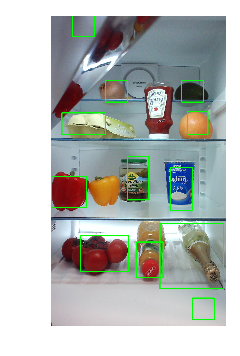

In [229]:
rois_with_prediction = test_rois[rois_prediction_indices]
rois_prediction_labels = rois_labels_predictions[rois_prediction_indices]
rois_predicion_scores = rois_values[rois_prediction_indices]
original_rois_predictions = original_rois[rois_prediction_indices]

original_img_cpy = original_img.copy()
for roi in original_rois_predictions:
    (x1,y1,x2,y2) = roi
    cv2.rectangle(original_img_cpy, (x1, y1), (x2, y2), (0, 255, 0), 5)

plt.imshow(cv2.cvtColor(original_img_cpy, cv2.COLOR_BGR2RGB))
plt.axis("off")